<a href="https://colab.research.google.com/github/Tatutina/HeartDisease_Project/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [64]:
heart = pd.read_csv('/content/drive/MyDrive/HeartDisease_Project/data/Sleep_health_and_lifestyle_dataset.csv')

In [65]:
print(f"✅ Данные загружены успешно!")
print(f"Размер данных: {heart.shape[0]} строк, {heart.shape[1]} столбцов")
print(f"\nТипы данных:")
print(heart.dtypes)
print(f"\nПервые 5 строк:")
print(heart.head())
print(f"\nИмена столбцов:")
print(list(heart.columns))

✅ Данные загружены успешно!
Размер данных: 374 строк, 13 столбцов

Типы данных:
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

Первые 5 строк:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activit

# Предобработка

In [66]:
# ============================================================================
# БЛОК 3: ФУНКЦИЯ ОЧИСТКИ ЧИСЛОВЫХ ЗНАЧЕНИЙ
# ============================================================================
print("=" * 70)
print("БЛОК 3: ФУНКЦИЯ ОЧИСТКИ ЧИСЛОВЫХ ЗНАЧЕНИЙ")
print("=" * 70)

def clean_numeric_values(series):
    """
    Очищает числовые значения от строковых форматов
    Пример: "126/83" → 104.5 (среднее значение)
    """
    cleaned = series.copy()

    for i, value in enumerate(series):
        if pd.isna(value):
            continue

        if isinstance(value, str):
            value = value.strip()

            # Обработка формата "126/83"
            if '/' in value:
                try:
                    parts = value.split('/')
                    if len(parts) == 2:
                        num1 = float(parts[0])
                        num2 = float(parts[1])
                        cleaned.iloc[i] = (num1 + num2) / 2
                        # print(f"  Преобразовано '{value}' → {cleaned.iloc[i]:.1f}")
                    else:
                        cleaned.iloc[i] = np.nan
                except:
                    cleaned.iloc[i] = np.nan

            # Замена запятых на точки
            elif ',' in value:
                cleaned.iloc[i] = float(value.replace(',', '.'))

            # Простое преобразование строки в число
            else:
                try:
                    cleaned.iloc[i] = float(value)
                except:
                    cleaned.iloc[i] = np.nan

    return cleaned

# Тестируем функцию на примере
print("🧪 Тестируем функцию очистки:")
test_data = pd.Series(["126/83", "120,5", "100", 150, np.nan, "не число"])
print(f"До очистки: {test_data.tolist()}")
print(f"После очистки: {clean_numeric_values(test_data).tolist()}")
print("✅ Функция очистки готова к использованию!")

БЛОК 3: ФУНКЦИЯ ОЧИСТКИ ЧИСЛОВЫХ ЗНАЧЕНИЙ
🧪 Тестируем функцию очистки:
До очистки: ['126/83', '120,5', '100', 150, nan, 'не число']
После очистки: [104.5, 120.5, 100.0, 150, nan, nan]
✅ Функция очистки готова к использованию!


In [67]:
# ============================================================================
# БЛОК 4: АНАЛИЗ ДАННЫХ И ОПРЕДЕЛЕНИЕ ТИПОВ СТОЛБЦОВ
# ============================================================================
print("=" * 70)
print("БЛОК 4: АНАЛИЗ ДАННЫХ И ОПРЕДЕЛЕНИЕ ТИПОВ СТОЛБЦОВ")
print("=" * 70)

def analyze_data(df, categorical_threshold=20):
    """
    Анализ данных и определение типов столбцов
    """
    print("\n🔍 АНАЛИЗ ДАННЫХ:")
    print("-" * 40)

    # Проверяем пропуски
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100

    print("📊 ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
    has_missing = False
    missing_cols = []

    for col in df.columns:
        if missing[col] > 0:
            has_missing = True
            missing_cols.append(col)
            print(f"  ⚠️  {col}: {missing[col]} пропусков ({missing_percent[col]:.1f}%)")

    if not has_missing:
        print("  ✅ Пропущенных значений нет")
    else:
        print(f"\n  📈 Всего столбцов с пропусками: {len(missing_cols)}")

    # Определяем типы столбцов
    categorical_cols = []
    numeric_cols = []

    print("\n🎯 ОПРЕДЕЛЕНИЕ ТИПОВ СТОЛБЦОВ:")
    print("-" * 40)

    for col in df.columns:
        dtype = df[col].dtype
        unique_count = df[col].nunique()

        if dtype == 'object':
            # Проверяем, может быть это числовые данные в строковом формате
            sample_values = df[col].dropna().head(5)
            has_slash = any(isinstance(v, str) and '/' in v for v in sample_values)
            has_comma = any(isinstance(v, str) and ',' in v for v in sample_values)

            if has_slash or has_comma:
                numeric_cols.append(col)
                print(f"  🔧 {col}: Строка → Числовой (есть '/', или ',')")
            elif unique_count <= categorical_threshold:
                categorical_cols.append(col)
                print(f"  🏷️  {col}: Категориальный ({unique_count} значений)")
            else:
                print(f"  📝 {col}: Текстовый/ID ({unique_count} значений)")
                categorical_cols.append(col)

        elif dtype in ['int64', 'float64']:
            if unique_count <= categorical_threshold and unique_count > 0:
                categorical_cols.append(col)
                print(f"  🔢 {col}: Числовой → Категориальный ({unique_count} значений)")
            else:
                numeric_cols.append(col)
                print(f"  📊 {col}: Числовой ({unique_count} значений)")
        else:
            print(f"  ❓ {col}: Неизвестный тип {dtype}")
            categorical_cols.append(col)

    print(f"\n📋 ИТОГО:")
    print(f"  🏷️  Категориальных столбцов: {len(categorical_cols)}")
    print(f"  📊 Числовых столбцов: {len(numeric_cols)}")
    print(f"  📝 Всего столбцов: {len(df.columns)}")

    return categorical_cols, numeric_cols

# Запускаем анализ
categorical_cols, numeric_cols = analyze_data(heart)

БЛОК 4: АНАЛИЗ ДАННЫХ И ОПРЕДЕЛЕНИЕ ТИПОВ СТОЛБЦОВ

🔍 АНАЛИЗ ДАННЫХ:
----------------------------------------
📊 ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
  ⚠️  Sleep Disorder: 219 пропусков (58.6%)

  📈 Всего столбцов с пропусками: 1

🎯 ОПРЕДЕЛЕНИЕ ТИПОВ СТОЛБЦОВ:
----------------------------------------
  📊 Person ID: Числовой (374 значений)
  🏷️  Gender: Категориальный (2 значений)
  📊 Age: Числовой (31 значений)
  🏷️  Occupation: Категориальный (11 значений)
  📊 Sleep Duration: Числовой (27 значений)
  🔢 Quality of Sleep: Числовой → Категориальный (6 значений)
  🔢 Physical Activity Level: Числовой → Категориальный (16 значений)
  🔢 Stress Level: Числовой → Категориальный (6 значений)
  🏷️  BMI Category: Категориальный (4 значений)
  🔧 Blood Pressure: Строка → Числовой (есть '/', или ',')
  🔢 Heart Rate: Числовой → Категориальный (19 значений)
  🔢 Daily Steps: Числовой → Категориальный (20 значений)
  🏷️  Sleep Disorder: Категориальный (2 значений)

📋 ИТОГО:
  🏷️  Категориальных столбцов: 9
  📊

In [68]:
# ============================================================================
# БЛОК 5: ПРЕДОБРАБОТКА ДАННЫХ
# ============================================================================
print("=" * 70)
print("БЛОК 5: ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 70)

def preprocess_data(df, categorical_cols, numeric_cols):
    """
    Предобработка данных: очистка, импутация, кодирование, масштабирование
    """
    print("🔄 НАЧИНАЕМ ПРЕДОБРАБОТКУ...")
    df_processed = df.copy()

    # 1. ОЧИСТКА ЧИСЛОВЫХ СТОЛБЦОВ
    print("\n1️⃣  ОЧИСТКА ЧИСЛОВЫХ СТОЛБЦОВ:")
    for col in numeric_cols:
        if col in df_processed.columns:
            if df_processed[col].dtype == 'object':
                original_dtype = df_processed[col].dtype
                df_processed[col] = clean_numeric_values(df_processed[col])
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
                print(f"  ✅ {col}: {original_dtype} → float64")

    # 2. ИМПУТАЦИЯ ПРОПУСКОВ
    print("\n2️⃣  ИМПУТАЦИЯ ПРОПУСКОВ:")

    # Числовые столбцы
    if numeric_cols:
        print("  📊 Числовые столбцы:")
        imputer_num = IterativeImputer(max_iter=10, random_state=42)
        numeric_data = df_processed[numeric_cols].select_dtypes(include=[np.number])

        if not numeric_data.empty:
            df_processed[numeric_data.columns] = imputer_num.fit_transform(numeric_data)
            print(f"    ✅ Заполнено {len(numeric_data.columns)} столбцов")

    # Категориальные столбцы
    if categorical_cols:
        print("  🏷️  Категориальные столбцы:")
        filled = 0
        for col in categorical_cols:
            if col in df_processed.columns and df_processed[col].isnull().sum() > 0:
                mode_val = df_processed[col].mode()
                if not mode_val.empty:
                    df_processed[col] = df_processed[col].fillna(mode_val[0])
                    filled += 1
        print(f"    ✅ Заполнено {filled} столбцов")

    # 3. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
    print("\n3️⃣  КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:")

    if categorical_cols:
        # Фильтруем столбцы для кодирования
        cols_to_encode = []
        for col in categorical_cols:
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].astype(str)
                unique_count = df_processed[col].nunique()
                if unique_count <= 15:  # Ограничиваем количество категорий
                    cols_to_encode.append(col)
                else:
                    print(f"    ⚠️  {col}: слишком много категорий ({unique_count})")

        if cols_to_encode:
            print(f"    🏷️  Будут закодированы: {cols_to_encode}")
            encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

            try:
                encoded_cats = encoder.fit_transform(df_processed[cols_to_encode])

                # Создаем новые имена столбцов
                encoded_cols = []
                for i, col in enumerate(cols_to_encode):
                    categories = encoder.categories_[i][1:]  # Пропускаем первую
                    for cat in categories:
                        encoded_cols.append(f"{col}_{cat}")

                encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cols, index=df_processed.index)

                # Удаляем исходные и добавляем новые
                df_processed = df_processed.drop(columns=cols_to_encode)
                df_processed = pd.concat([df_processed, encoded_df], axis=1)

                print(f"    ✅ Создано {len(encoded_cols)} новых бинарных столбцов")

            except Exception as e:
                print(f"    ❌ Ошибка: {e}")

    # 4. МАСШТАБИРОВАНИЕ
    print("\n4️⃣  МАСШТАБИРОВАНИЕ:")

    # Находим числовые столбцы
    numeric_cols_for_scaling = df_processed.select_dtypes(include=[np.number]).columns.tolist()

    if numeric_cols_for_scaling:
        scaler = StandardScaler()
        df_processed[numeric_cols_for_scaling] = scaler.fit_transform(df_processed[numeric_cols_for_scaling])
        print(f"    ✅ Масштабировано {len(numeric_cols_for_scaling)} столбцов")
    else:
        print("    ⚠️  Нет числовых столбцов для масштабирования")

    print(f"\n🎉 ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print(f"   📊 Исходный размер: {df.shape}")
    print(f"   📈 После обработки: {df_processed.shape}")

    return df_processed

# Запускаем предобработку
heart_processed = preprocess_data(heart, categorical_cols, numeric_cols)

БЛОК 5: ПРЕДОБРАБОТКА ДАННЫХ
🔄 НАЧИНАЕМ ПРЕДОБРАБОТКУ...

1️⃣  ОЧИСТКА ЧИСЛОВЫХ СТОЛБЦОВ:
  ✅ Blood Pressure: object → float64

2️⃣  ИМПУТАЦИЯ ПРОПУСКОВ:
  📊 Числовые столбцы:
    ✅ Заполнено 4 столбцов
  🏷️  Категориальные столбцы:
    ✅ Заполнено 1 столбцов

3️⃣  КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:
    ⚠️  Physical Activity Level: слишком много категорий (16)
    ⚠️  Heart Rate: слишком много категорий (19)
    ⚠️  Daily Steps: слишком много категорий (20)
    🏷️  Будут закодированы: ['Gender', 'Occupation', 'Quality of Sleep', 'Stress Level', 'BMI Category', 'Sleep Disorder']
    ✅ Создано 25 новых бинарных столбцов

4️⃣  МАСШТАБИРОВАНИЕ:
    ✅ Масштабировано 29 столбцов

🎉 ПРЕДОБРАБОТКА ЗАВЕРШЕНА!
   📊 Исходный размер: (374, 13)
   📈 После обработки: (374, 32)


# Кластерный анализ

In [69]:
# ============================================================================
# БЛОК 6: ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ
# ============================================================================
print("=" * 70)
print("БЛОК 6: ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ")
print("=" * 70)

print("🎯 ПОДГОТОВКА ДАННЫХ:")
print("-" * 40)

# Сохраняем целевую переменную отдельно
if 'ССЗ' in heart.columns:
    y_true = heart['ССЗ'].copy()
    print(f"✅ Целевая переменная 'ССЗ' сохранена")
    print(f"   📊 Распределение ССЗ:")
    print(f"     0 (нет ССЗ): {(y_true == 0).sum()} пациентов")
    print(f"     1 (есть ССЗ): {(y_true == 1).sum()} пациентов")
    print(f"   📈 Процент ССЗ: {(y_true.mean() * 100):.1f}%")
else:
    y_true = None
    print("⚠️  Целевая переменная 'ССЗ' не найдена")

# Убираем целевую переменную для кластеризации
if 'ССЗ' in heart_processed.columns:
    X = heart_processed.drop(columns=['ССЗ'])
    print(f"\n✅ Данные для кластеризации подготовлены")
    print(f"   🎯 Убрана целевая переменная 'ССЗ'")
    print(f"   📊 Размер X: {X.shape}")
else:
    X = heart_processed.copy()
    print(f"\n✅ Данные для кластеризации подготовлены")
    print(f"   📊 Размер X: {X.shape}")

# Проверяем типы данных
print(f"\n🔍 ТИПЫ ДАННЫХ В X:")
print(X.dtypes.value_counts())

# Показываем первые 3 строки
print(f"\n👀 ПЕРВЫЕ 3 СТРОКИ ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ:")
print(X.head(3))

БЛОК 6: ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ
🎯 ПОДГОТОВКА ДАННЫХ:
----------------------------------------
⚠️  Целевая переменная 'ССЗ' не найдена

✅ Данные для кластеризации подготовлены
   📊 Размер X: (374, 32)

🔍 ТИПЫ ДАННЫХ В X:
float64    29
object      3
Name: count, dtype: int64

👀 ПЕРВЫЕ 3 СТРОКИ ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ:
   Person ID       Age  Sleep Duration Physical Activity Level  \
0  -1.727426 -1.753096       -1.298887                      42   
1  -1.718163 -1.637643       -1.173036                      60   
2  -1.708901 -1.637643       -1.173036                      60   

   Blood Pressure Heart Rate Daily Steps  Gender_Male  Occupation_Doctor  \
0       -0.304627         77        4200     0.989361          -0.484070   
1       -0.594527         75       10000     0.989361           2.065818   
2       -0.594527         75       10000     0.989361           2.065818   

   Occupation_Engineer  ...  Quality of Sleep_9  Stress Level_4  \
0             -0.45008  ...     

БЛОК 7: ПОИСК ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ
🔍 ИЩЕМ ОПТИМАЛЬНОЕ КОЛИЧЕСТВО КЛАСТЕРОВ...
   📊 Используется 29 числовых признаков
   🔍 Проверяем от 2 до 8 кластеров

📊 РЕЗУЛЬТАТЫ ОЦЕНКИ:
--------------------------------------------------
Кластеров  Silhouette   Davies-Bouldin 
--------------------------------------------------
2          0.214        2.203          
3          0.262        1.763          
4          0.323        1.604          
5          0.368        1.393          
6          0.435        1.232          
7          0.458        1.209          
8          0.538        1.026          
--------------------------------------------------
🎯 ОПТИМАЛЬНОЕ ЧИСЛО КЛАСТЕРОВ: 8
   📈 Лучший Silhouette Score: 0.538

📈 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:


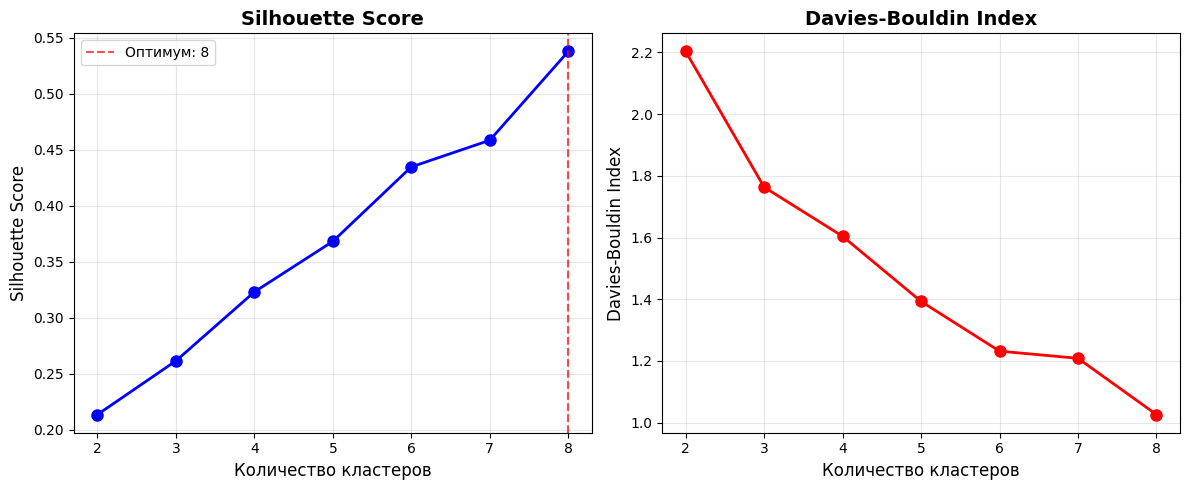

In [70]:
# ============================================================================
# БЛОК 7: ПОИСК ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ
# ============================================================================
print("=" * 70)
print("БЛОК 7: ПОИСК ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ")
print("=" * 70)

def find_optimal_clusters(X, max_clusters=8):
    """
    Поиск оптимального количества кластеров по метрикам
    """
    print("🔍 ИЩЕМ ОПТИМАЛЬНОЕ КОЛИЧЕСТВО КЛАСТЕРОВ...")

    # Убедимся, что X содержит только числа
    X_numeric = X.select_dtypes(include=[np.number]) if hasattr(X, 'select_dtypes') else X

    if X_numeric.shape[1] == 0:
        print("⚠️  Нет числовых признаков для кластеризации")
        return 3

    print(f"   📊 Используется {X_numeric.shape[1]} числовых признаков")

    silhouette_scores = []
    db_scores = []

    # Определяем диапазон для поиска
    cluster_range = range(2, min(max_clusters + 1, len(X_numeric) // 10 + 2))
    print(f"   🔍 Проверяем от {min(cluster_range)} до {max(cluster_range)} кластеров")

    print("\n📊 РЕЗУЛЬТАТЫ ОЦЕНКИ:")
    print("-" * 50)
    print(f"{'Кластеров':<10} {'Silhouette':<12} {'Davies-Bouldin':<15}")
    print("-" * 50)

    for n in cluster_range:
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_numeric)

        if len(np.unique(clusters)) > 1:
            try:
                silhouette = silhouette_score(X_numeric, clusters)
                db = davies_bouldin_score(X_numeric, clusters)
            except:
                silhouette = 0
                db = 10
        else:
            silhouette = 0
            db = 10

        silhouette_scores.append(silhouette)
        db_scores.append(db)

        print(f"{n:<10} {silhouette:<12.3f} {db:<15.3f}")

    # Находим оптимальное количество
    if silhouette_scores:
        optimal_n = cluster_range[np.argmax(silhouette_scores)]
        best_silhouette = max(silhouette_scores)
        print("-" * 50)
        print(f"🎯 ОПТИМАЛЬНОЕ ЧИСЛО КЛАСТЕРОВ: {optimal_n}")
        print(f"   📈 Лучший Silhouette Score: {best_silhouette:.3f}")
    else:
        optimal_n = 3
        print(f"⚠️  Используем значение по умолчанию: {optimal_n}")

    # ВИЗУАЛИЗАЦИЯ
    print("\n📈 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")

    if len(silhouette_scores) > 1:
        plt.figure(figsize=(12, 5))

        # График 1: Silhouette Score
        plt.subplot(1, 2, 1)
        plt.plot(cluster_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
        plt.axvline(x=optimal_n, color='red', linestyle='--', alpha=0.7, label=f'Оптимум: {optimal_n}')
        plt.xlabel('Количество кластеров', fontsize=12)
        plt.ylabel('Silhouette Score', fontsize=12)
        plt.title('Silhouette Score', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # График 2: Davies-Bouldin Index
        plt.subplot(1, 2, 2)
        plt.plot(cluster_range, db_scores, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Количество кластеров', fontsize=12)
        plt.ylabel('Davies-Bouldin Index', fontsize=12)
        plt.title('Davies-Bouldin Index', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('optimal_clusters.png', dpi=300, bbox_inches='tight')
        plt.show()

    return optimal_n

# Запускаем поиск оптимального числа кластеров
optimal_n = find_optimal_clusters(X, max_clusters=8)

In [71]:
# ============================================================================
# БЛОК 8: ВЫПОЛНЕНИЕ КЛАСТЕРИЗАЦИИ
# ============================================================================
print("=" * 70)
print("БЛОК 8: ВЫПОЛНЕНИЕ КЛАСТЕРИЗАЦИИ")
print("=" * 70)

def perform_clustering(X, n_clusters, method='kmeans'):
    """
    Выполнение кластеризации и оценка результатов
    """
    print(f"🎯 ЗАПУСК КЛАСТЕРИЗАЦИИ ({method.upper()})")
    print(f"   📊 Количество кластеров: {n_clusters}")

    # Убедимся, что X содержит только числа
    X_numeric = X.select_dtypes(include=[np.number]) if hasattr(X, 'select_dtypes') else X

    if X_numeric.shape[1] == 0:
        print("❌ Нет числовых признаков для кластеризации")
        return np.zeros(len(X))

    print(f"   🔢 Используется {X_numeric.shape[1]} признаков")

    # Выполняем кластеризацию
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif method == 'hierarchical':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("Метод должен быть 'kmeans' или 'hierarchical'")

    clusters = model.fit_predict(X_numeric)

    # ОЦЕНКА КАЧЕСТВА
    print("\n📊 ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ:")
    print("-" * 40)

    if len(np.unique(clusters)) > 1:
        try:
            silhouette = silhouette_score(X_numeric, clusters)
            db = davies_bouldin_score(X_numeric, clusters)

            print(f"   Silhouette Score: {silhouette:.3f}")
            print(f"   Davies-Bouldin Index: {db:.3f}")

            # Интерпретация качества
            print(f"\n🎯 ИНТЕРПРЕТАЦИЯ:")
            if silhouette > 0.7:
                print("   ✅ ОТЛИЧНАЯ КЛАСТЕРИЗАЦИЯ")
                print("      Четкие, хорошо разделенные кластеры")
            elif silhouette > 0.5:
                print("   👍 ХОРОШАЯ КЛАСТЕРИЗАЦИЯ")
                print("      Умеренное разделение кластеров")
            elif silhouette > 0.25:
                print("   ⚠️  УДОВЛЕТВОРИТЕЛЬНАЯ КЛАСТЕРИЗАЦИЯ")
                print("      Слабое разделение, но структура есть")
            else:
                print("   ❌ ПЛОХАЯ КЛАСТЕРИЗАЦИЯ")
                print("      Кластеры плохо разделены")
        except Exception as e:
            print(f"   ⚠️  Не удалось оценить качество: {e}")

    # РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ
    print("\n📈 РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:")
    print("-" * 40)

    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        percentage = (count / len(clusters)) * 100
        bar = '█' * int(percentage / 5)  # Визуализация барами
        print(f"   Кластер {cluster}: {count:3d} объектов ({percentage:5.1f}%) {bar}")

    return clusters

# Запускаем кластеризацию
clusters = perform_clustering(X, n_clusters=optimal_n, method='kmeans')
print(f"\n✅ КЛАСТЕРИЗАЦИЯ ВЫПОЛНЕНА!")
print(f"   🏷️  Создано {len(np.unique(clusters))} кластеров")

БЛОК 8: ВЫПОЛНЕНИЕ КЛАСТЕРИЗАЦИИ
🎯 ЗАПУСК КЛАСТЕРИЗАЦИИ (KMEANS)
   📊 Количество кластеров: 8
   🔢 Используется 29 признаков

📊 ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ:
----------------------------------------
   Silhouette Score: 0.538
   Davies-Bouldin Index: 1.026

🎯 ИНТЕРПРЕТАЦИЯ:
   👍 ХОРОШАЯ КЛАСТЕРИЗАЦИЯ
      Умеренное разделение кластеров

📈 РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:
----------------------------------------
   Кластер 0:  34 объектов (  9.1%) █
   Кластер 1:  56 объектов ( 15.0%) ██
   Кластер 2:  69 объектов ( 18.4%) ███
   Кластер 3:  65 объектов ( 17.4%) ███
   Кластер 4:  39 объектов ( 10.4%) ██
   Кластер 5:  40 объектов ( 10.7%) ██
   Кластер 6:  36 объектов (  9.6%) █
   Кластер 7:  35 объектов (  9.4%) █

✅ КЛАСТЕРИЗАЦИЯ ВЫПОЛНЕНА!
   🏷️  Создано 8 кластеров


# Визуализация

БЛОК 9: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ
🎨 СОЗДАЕМ ВИЗУАЛИЗАЦИИ...

1️⃣  PCA ВИЗУАЛИЗАЦИЯ:
   📊 Объясненная дисперсия:
      PC1: 0.176 (17.6%)
      PC2: 0.145 (14.5%)
      Всего: 0.321 (32.1%)


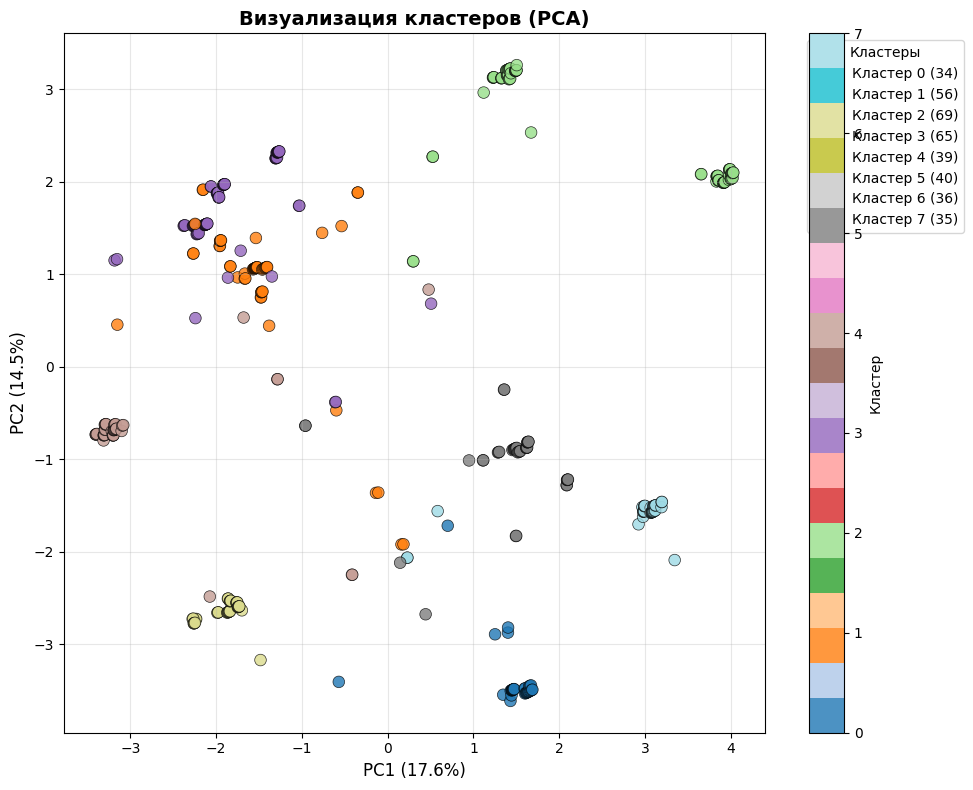


2️⃣  ТЕПЛОВАЯ КАРТА СРЕДНИХ ЗНАЧЕНИЙ:
   📊 Слишком много признаков (29)
   🔍 Показываем топ-15 по дисперсии


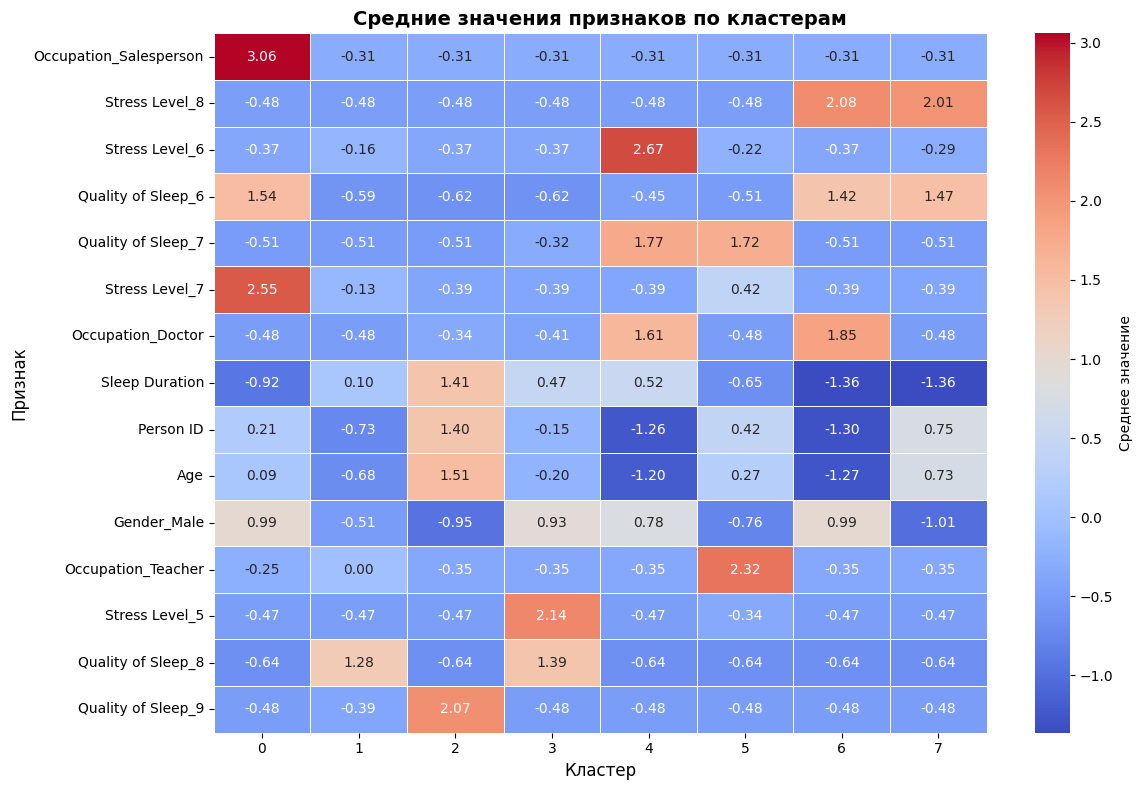

   ✅ Показано 15 признаков

3️⃣  ДЕНДРОГРАММА:
   ⚠️  Слишком много данных для дендрограммы

✅ ВИЗУАЛИЗАЦИЯ ЗАВЕРШЕНА!
   📁 Созданы файлы:
      - pca_clusters.png
      - cluster_means.png
      - dendrogram.png (если было возможно)


In [72]:
# ============================================================================
# БЛОК 9: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ
# ============================================================================
print("=" * 70)
print("БЛОК 9: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ")
print("=" * 70)

def visualize_clusters(X, clusters, feature_names=None):
    """
    Визуализация результатов кластеризации
    """
    print("🎨 СОЗДАЕМ ВИЗУАЛИЗАЦИИ...")

    # 1. PCA ВИЗУАЛИЗАЦИЯ
    print("\n1️⃣  PCA ВИЗУАЛИЗАЦИЯ:")

    X_numeric = X.select_dtypes(include=[np.number]) if hasattr(X, 'select_dtypes') else X

    if X_numeric.shape[1] >= 2:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(X_numeric)

        explained_variance = pca.explained_variance_ratio_
        print(f"   📊 Объясненная дисперсия:")
        print(f"      PC1: {explained_variance[0]:.3f} ({explained_variance[0]*100:.1f}%)")
        print(f"      PC2: {explained_variance[1]:.3f} ({explained_variance[1]*100:.1f}%)")
        print(f"      Всего: {sum(explained_variance):.3f} ({sum(explained_variance)*100:.1f}%)")

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                             c=clusters, cmap='tab20', s=70, alpha=0.8,
                             edgecolor='black', linewidth=0.5)

        plt.colorbar(scatter, label='Кластер')
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)
        plt.title('Визуализация кластеров (PCA)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

        # Добавляем легенду с размерами кластеров
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            count = (clusters == cluster).sum()
            plt.scatter([], [], c=[plt.cm.tab20(cluster/len(unique_clusters))],
                       label=f'Кластер {cluster} ({count})', s=50)

        plt.legend(title='Кластеры', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('pca_clusters.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("   ⚠️  Недостаточно признаков для PCA")

    # 2. ТЕПЛОВАЯ КАРТА СРЕДНИХ ЗНАЧЕНИЙ
    print("\n2️⃣  ТЕПЛОВАЯ КАРТА СРЕДНИХ ЗНАЧЕНИЙ:")

    if feature_names is not None and len(feature_names) > 0:
        # Создаем DataFrame с кластерами
        clustered_data = pd.DataFrame(X_numeric, columns=feature_names[:X_numeric.shape[1]])
        clustered_data['Кластер'] = clusters

        # Считаем средние по кластерам
        cluster_means = clustered_data.groupby('Кластер').mean()

        # Ограничиваем количество признаков
        if cluster_means.shape[1] > 15:
            print(f"   📊 Слишком много признаков ({cluster_means.shape[1]})")
            print(f"   🔍 Показываем топ-15 по дисперсии")

            # Выбираем признаки с наибольшей дисперсией
            variance = cluster_means.var()
            top_features = variance.nlargest(15).index
            cluster_means = cluster_means[top_features]

        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_means.T, cmap='coolwarm', annot=True,
                   fmt=".2f", linewidths=0.5,
                   cbar_kws={'label': 'Среднее значение'})

        plt.title('Средние значения признаков по кластерам', fontsize=14, fontweight='bold')
        plt.xlabel('Кластер', fontsize=12)
        plt.ylabel('Признак', fontsize=12)
        plt.tight_layout()
        plt.savefig('cluster_means.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"   ✅ Показано {cluster_means.shape[1]} признаков")
    else:
        print("   ⚠️  Нет имен признаков для тепловой карты")

    # 3. ДЕНДРОГРАММА (если данных не слишком много)
    print("\n3️⃣  ДЕНДРОГРАММА:")

    if len(clusters) <= 100:
        plt.figure(figsize=(15, 7))
        linkage_matrix = linkage(X_numeric, method='ward')
        dendrogram(linkage_matrix, truncate_mode='level', p=10)

        plt.title('Дендрограмма иерархической кластеризации', fontsize=14, fontweight='bold')
        plt.xlabel('Объекты (пациенты)', fontsize=12)
        plt.ylabel('Расстояние', fontsize=12)
        plt.tight_layout()
        plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("   ✅ Дендрограмма создана")
    else:
        print("   ⚠️  Слишком много данных для дендрограммы")

    print("\n✅ ВИЗУАЛИЗАЦИЯ ЗАВЕРШЕНА!")
    print("   📁 Созданы файлы:")
    print("      - pca_clusters.png")
    print("      - cluster_means.png")
    print("      - dendrogram.png (если было возможно)")

# Запускаем визуализацию
# Получаем имена признаков
if hasattr(X, 'columns'):
    feature_names = X.columns.tolist()
else:
    feature_names = [f"Признак_{i}" for i in range(X.shape[1])]

visualize_clusters(X, clusters, feature_names)

# Основной рабочий процесс

In [76]:
# ============================================================================
# БЛОК 11: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================================================
print("=" * 70)
print("БЛОК 11: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 70)

print("💾 СОХРАНЯЕМ РЕЗУЛЬТАТЫ АНАЛИЗА...")

# 1. Добавляем кластеры к исходным данным
heart_with_clusters = heart.copy()
heart_with_clusters['Кластер'] = clusters

if y_true is not None:
    heart_with_clusters['ССЗ_истинный'] = y_true.values

# 2. Сохраняем в CSV
heart_with_clusters.to_csv('/content/drive/MyDrive/HeartDisease_Project/data/heart_with_clusters.csv', index=False, encoding='utf-8')
print(f"✅ 1. Данные с кластерами сохранены: heart_with_clusters.csv")
print(f"   📊 Размер: {heart_with_clusters.shape}")

# 4. Создаем отчет
print("\n📋 ИТОГОВЫЙ ОТЧЕТ:")
print("-" * 40)
print(f"🎯 Цель анализа: Кластеризация пациентов по риску ССЗ")
print(f"📊 Исходные данные: {heart.shape[0]} пациентов, {heart.shape[1]} признаков")
print(f"🔢 Оптимальное число кластеров: {optimal_n}")
print(f"📈 Качество кластеризации (Silhouette): {silhouette_score(X.select_dtypes(include=[np.number]), clusters):.3f}")

if y_true is not None:
    from scipy.stats import chi2_contingency
    contingency_table = pd.crosstab(clusters, y_true)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"📊 Связь с ССЗ: {'ЕСТЬ' if p_value < 0.05 else 'НЕТ'} (p={p_value:.4f})")

    # Находим самый рискованный кластер
    ssz_by_cluster = pd.crosstab(clusters, y_true, normalize='index')[1] * 100
    riskiest = ssz_by_cluster.idxmax()
    risk_rate = ssz_by_cluster.max()

    print(f"🎯 Самый рискованный кластер: {riskiest} ({risk_rate:.1f}% ССЗ)")

print(f"\n📁 СОЗДАННЫЕ ФАЙЛЫ:")
print("   1. heart_with_clusters.csv - данные с кластерами")
print("   3. optimal_clusters.png - график оптимального числа кластеров")
print("   4. pca_clusters.png - PCA визуализация")
print("   5. cluster_means.png - тепловая карта средних значений")
print("   6. clusters_vs_ssz.png - сравнение кластеров с ССЗ")
print("   7. dendrogram.png - дендрограмма")

print("\n🎉 АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
print("=" * 70)

БЛОК 11: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
💾 СОХРАНЯЕМ РЕЗУЛЬТАТЫ АНАЛИЗА...
✅ 1. Данные с кластерами сохранены: heart_with_clusters.csv
   📊 Размер: (374, 14)

📋 ИТОГОВЫЙ ОТЧЕТ:
----------------------------------------
🎯 Цель анализа: Кластеризация пациентов по риску ССЗ
📊 Исходные данные: 374 пациентов, 13 признаков
🔢 Оптимальное число кластеров: 8
📈 Качество кластеризации (Silhouette): 0.538

📁 СОЗДАННЫЕ ФАЙЛЫ:
   1. heart_with_clusters.csv - данные с кластерами
   3. optimal_clusters.png - график оптимального числа кластеров
   4. pca_clusters.png - PCA визуализация
   5. cluster_means.png - тепловая карта средних значений
   6. clusters_vs_ssz.png - сравнение кластеров с ССЗ
   7. dendrogram.png - дендрограмма

🎉 АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!
